In [6]:
import pandas as pd
import numpy as np

# Load the csv containing the 512-D vectors for the B-Mode images
df_B_mode_train = pd.read_csv('../Custom_CNN_B_Mode_Stratified/train_features_custom_CNN.csv')
df_B_mode_test = pd.read_csv('../Custom_CNN_B_Mode_Stratified/test_features_custom_CNN.csv')

# Load the csv containing the 512-D vectors for the Enhancement images
df_IE_train = pd.read_csv('../Custom_CNN_IE_Stratified/train_features_custom_CNN.csv')
df_IE_test = pd.read_csv('../Custom_CNN_IE_Stratified/test_features_custom_CNN.csv')

# Load the csv containing the 512-D vectors for the Quality Improved images
df_IQ_train = pd.read_csv('../Custom_CNN_IQ_Stratified/train_features_custom_CNN.csv')
df_IQ_test = pd.read_csv('../Custom_CNN_IQ_Stratified/test_features_custom_CNN.csv')

#############################################################
######## This is for combining the datasets vertically ########
# ✅ Concatenate train sets vertically
df_train_combined = pd.concat([df_B_mode_train, df_IE_train, df_IQ_train], axis=0).reset_index(drop=True)

# ✅ Concatenate test sets vertically
df_test_combined = pd.concat([df_B_mode_test, df_IE_test, df_IQ_test], axis=0).reset_index(drop=True)

# ✅ Print shape to verify
print(f"Train Data Shape: {df_train_combined.shape}")
print(f"Test Data Shape: {df_test_combined.shape}")

# ✅ Save concatenated datasets
df_train_combined.to_csv('train_features_multi_modal.csv', index=False)
df_test_combined.to_csv('test_features_multi_modal.csv', index=False)

print("🔥 Multi-modality datasets saved successfully!")
################################################################
################################################################


###############################################################
######## This is for merging the datasets horizontally ########
# Get feature columns (excluding 'Image' and 'Label')
feature_columns_B_mode = df_B_mode_train.columns[1:-1]  # 512 features
feature_columns_IE = df_IE_train.columns[1:-1]  # 512 features
feature_columns_IQ = df_IQ_train.columns[1:-1]  # 512 features
label_column = df_B_mode_train.columns[-1]  # 'Label' column

### ✅ Remove 'Label' columns from df_IE and df_IQ before merging ###
df_IE_train = df_IE_train.drop(columns=[label_column])
df_IE_test = df_IE_test.drop(columns=[label_column])
df_IQ_train = df_IQ_train.drop(columns=[label_column])
df_IQ_test = df_IQ_test.drop(columns=[label_column])

# ✅ Merge train features using 'Image' as reference and retain Image column
df_train_merged = df_B_mode_train[['Image', label_column]].copy()  # Keep 'Image' and 'Label'
df_train_merged = df_train_merged.merge(df_B_mode_train[['Image'] + list(feature_columns_B_mode)], on='Image', how='left')
df_train_merged = df_train_merged.merge(df_IE_train[['Image'] + list(feature_columns_IE)], on='Image', how='left')
df_train_merged = df_train_merged.merge(df_IQ_train[['Image'] + list(feature_columns_IQ)], on='Image', how='left')

# ✅ Merge test features using 'Image' as reference and retain Image column
df_test_merged = df_B_mode_test[['Image', label_column]].copy()  # Keep 'Image' and 'Label'
df_test_merged = df_test_merged.merge(df_B_mode_test[['Image'] + list(feature_columns_B_mode)], on='Image', how='left')
df_test_merged = df_test_merged.merge(df_IE_test[['Image'] + list(feature_columns_IE)], on='Image', how='left')
df_test_merged = df_test_merged.merge(df_IQ_test[['Image'] + list(feature_columns_IQ)], on='Image', how='left')

# ✅ Ensure no duplicate Image or Label columns exist
df_train_merged = df_train_merged.loc[:, ~df_train_merged.columns.duplicated()]
df_test_merged = df_test_merged.loc[:, ~df_test_merged.columns.duplicated()]

# ✅ Save the merged files WITH Image Names
df_train_merged.to_csv('train_features_merged.csv', index=False)
df_test_merged.to_csv('test_features_merged.csv', index=False)

# ✅ Check final shape
print(f"Train merged shape: {df_train_merged.shape}")  # Expected: (Num_Train_Samples, 1537) (Image + 1536 Features + Label)
print(f"Test merged shape: {df_test_merged.shape}")  # Expected: (Num_Test_Samples, 1537) (Image + 1536 Features + Label)
################################################################
################################################################

Train Data Shape: (29367, 514)
Test Data Shape: (7833, 514)
🔥 Multi-modality datasets saved successfully!
Train merged shape: (9789, 1538)
Test merged shape: (2611, 1538)


In [9]:
from torch.utils.data import Dataset

# ✅ Custom Dataset Class that includes Image Names
class CustomFeatureDataset(Dataset):
    def __init__(self, features, labels, image_names):
        self.features = features
        self.labels = labels
        self.image_names = image_names

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        img_name = self.image_names[idx]
        return x, y, img_name  # ✅ Return image name with features and label

In [10]:
import torch

# Convert labels to integers and ensure correct dtype (torch.long for classification)
y_train = torch.tensor(df_train_merged['Label'].to_numpy(), dtype=torch.long)
y_test = torch.tensor(df_test_merged['Label'].to_numpy(), dtype=torch.long)

# Convert feature matrices to float32 (important for model computations)
X_train = torch.tensor(df_train_merged.drop(columns=['Image', 'Label']).to_numpy(), dtype=torch.float32)
X_test = torch.tensor(df_test_merged.drop(columns=['Image', 'Label']).to_numpy(), dtype=torch.float32)

# ✅ Track Image Names as Numpy Arrays
image_names_train = df_train_merged['Image'].to_numpy()
image_names_test = df_test_merged['Image'].to_numpy()

# ✅ Create the train and test datasets using the Custom Dataset Class
train_dataset = CustomFeatureDataset(X_train, y_train, image_names_train)
test_dataset = CustomFeatureDataset(X_test, y_test, image_names_test)

# ✅ Create the train and test data loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Train MLP with the concatenated features:
- The MLP acts as a feature projector, reducing redundancy and learning meaningful interactions between modalities.

Training:   2%|▏         | 1/50 [00:01<00:55,  1.13s/it]

Epoch 1: Train Loss=1.2086, Train Acc=66.03%, Val Loss=0.8553, Val Acc=87.25%
✅ Best model saved (Epoch 1, Val Acc=87.25%)


Training:   4%|▍         | 2/50 [00:02<00:49,  1.02s/it]

Epoch 2: Train Loss=0.7948, Train Acc=87.23%, Val Loss=0.7386, Val Acc=89.16%
✅ Best model saved (Epoch 2, Val Acc=89.16%)


Training:   6%|▌         | 3/50 [00:03<00:48,  1.04s/it]

Epoch 3: Train Loss=0.7050, Train Acc=90.64%, Val Loss=0.6922, Val Acc=90.16%
✅ Best model saved (Epoch 3, Val Acc=90.16%)


Training:   8%|▊         | 4/50 [00:04<00:45,  1.01it/s]

Epoch 4: Train Loss=0.6595, Train Acc=92.67%, Val Loss=0.6729, Val Acc=90.23%
✅ Best model saved (Epoch 4, Val Acc=90.23%)


Training:  10%|█         | 5/50 [00:04<00:42,  1.06it/s]

Epoch 5: Train Loss=0.6376, Train Acc=93.46%, Val Loss=0.6658, Val Acc=90.46%
✅ Best model saved (Epoch 5, Val Acc=90.46%)


Training:  12%|█▏        | 6/50 [00:05<00:40,  1.09it/s]

Epoch 6: Train Loss=0.6197, Train Acc=94.40%, Val Loss=0.6587, Val Acc=90.77%
✅ Best model saved (Epoch 6, Val Acc=90.77%)


Training:  14%|█▍        | 7/50 [00:06<00:38,  1.12it/s]

Epoch 7: Train Loss=0.6077, Train Acc=94.81%, Val Loss=0.6565, Val Acc=90.54%


Training:  16%|█▌        | 8/50 [00:07<00:37,  1.13it/s]

Epoch 8: Train Loss=0.6045, Train Acc=94.89%, Val Loss=0.6563, Val Acc=90.85%
✅ Best model saved (Epoch 8, Val Acc=90.85%)


Training:  18%|█▊        | 9/50 [00:08<00:41,  1.02s/it]

Epoch 9: Train Loss=0.5951, Train Acc=95.00%, Val Loss=0.6544, Val Acc=90.69%


Training:  20%|██        | 10/50 [00:09<00:42,  1.05s/it]

Epoch 10: Train Loss=0.5879, Train Acc=95.45%, Val Loss=0.6518, Val Acc=90.96%
✅ Best model saved (Epoch 10, Val Acc=90.96%)


Training:  22%|██▏       | 11/50 [00:10<00:40,  1.04s/it]

Epoch 11: Train Loss=0.5831, Train Acc=95.48%, Val Loss=0.6572, Val Acc=90.35%


Training:  24%|██▍       | 12/50 [00:12<00:41,  1.09s/it]

Epoch 12: Train Loss=0.5811, Train Acc=95.85%, Val Loss=0.6524, Val Acc=90.77%


Training:  26%|██▌       | 13/50 [00:13<00:38,  1.04s/it]

Epoch 13: Train Loss=0.5748, Train Acc=96.10%, Val Loss=0.6550, Val Acc=90.85%


Training:  28%|██▊       | 14/50 [00:13<00:36,  1.00s/it]

Epoch 14: Train Loss=0.5715, Train Acc=96.11%, Val Loss=0.6492, Val Acc=90.69%


Training:  28%|██▊       | 14/50 [00:14<00:38,  1.06s/it]

Epoch 15: Train Loss=0.5661, Train Acc=96.23%, Val Loss=0.6488, Val Acc=90.81%
⏹ Stopping early at epoch 15. Best Val Acc: 90.96%


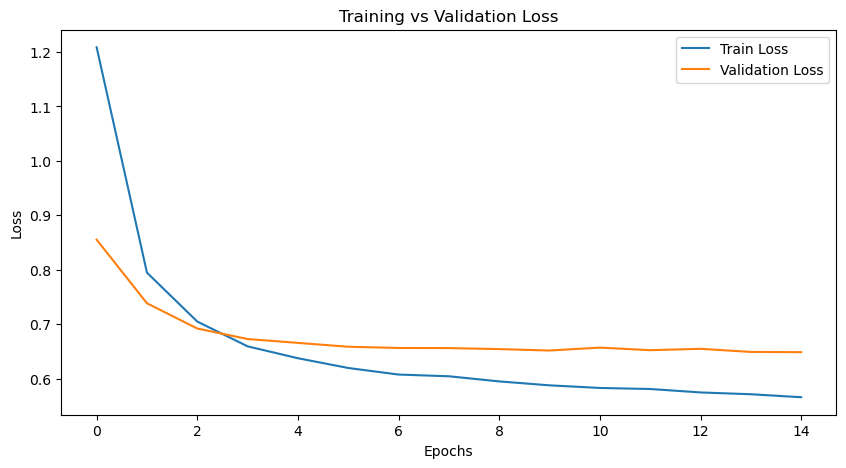

✅ Model training complete and saved successfully!


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score



# ✅ MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim1=512, hidden_dim2=256, output_dim=6):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
   
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        return self.fc3(x)

    def extract_features(self, x):
        """Extracts 256-dimensional feature vector before the final classification layer."""
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)  # Extracted feature layer
        return x
    
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ✅ Define the model, loss function and optimizer
input_dim = 1536  # 1536 features (512 * 3)
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 6  # 6 classes
learning_rate = 0.0005

model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)

# ✅ Define loss function with class weights
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-3)

# ✅ Early stopping parameters (based on validation accuracy)
best_val_acc = 0.0
patience = 5  # Stop if validation accuracy doesn't improve for 10 epochs
counter = 0

# ✅ Lists to store losses
train_losses = []
val_losses = []

# ✅ Training loop
num_epochs = 50  # Set high, but will stop early if necessary

for epoch in tqdm(range(num_epochs), desc="Training", total=num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    # Training step
    for images, labels, img_names in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Compute training accuracy
    train_acc = 100 * correct / total
    train_losses.append(epoch_loss / len(train_loader))

    # Validation step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels, img_names in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Compute validation accuracy
    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_losses[-1]:.4f}, Val Acc={val_acc:.2f}%")

    # ✅ Early Stopping Logic (Based on Validation Accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_mlp.pth")  # Save best model
        print(f"✅ Best model saved (Epoch {epoch+1}, Val Acc={best_val_acc:.2f}%)")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹ Stopping early at epoch {epoch+1}. Best Val Acc: {best_val_acc:.2f}%")
            break

# ✅ Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

print("✅ Model training complete and saved successfully!")

In [12]:
import torch
import numpy as np
import pandas as pd

# Load the best model and extract features
model.load_state_dict(torch.load("best_mlp.pth"))  # Ensure best model is used
model.eval()

# ✅ Extract MLP Features with Image Names Preserved
X_train_features = []
y_train_labels = []
img_train_names = []  # Track Image Names
X_test_features = []
y_test_labels = []
img_test_names = []  # Track Image Names

pseudo_probs_train = []  # ✅ Store all class probabilities (shape: num_samples x num_classes)
pseudo_probs_test = []   # ✅ Store all class probabilities (shape: num_samples x num_classes)

with torch.no_grad():
    for images, labels, img_names in train_loader:
        images = images.to(device)
        features = model.extract_features(images)
        X_train_features.append(features.cpu().numpy())
        y_train_labels.append(labels.cpu().numpy())
        img_train_names.extend(img_names)  # ✅ Track corresponding shuffled image names
        
        # ✅ Get pseudo labels and confidence scores for training data (store all class probabilities)
        outputs = torch.softmax(model(images), dim=1)  # Convert logits to probabilities
        pseudo_probs_train.append(outputs.cpu().numpy())  # ✅ Store full probability distribution

    for images, labels, img_names in test_loader:
        images = images.to(device)
        features = model.extract_features(images)
        X_test_features.append(features.cpu().numpy())
        y_test_labels.append(labels.cpu().numpy())
        img_test_names.extend(img_names)  # ✅ Track corresponding shuffled image names
        
        # ✅ Get pseudo labels and confidence scores for test data (store all class probabilities)
        outputs = torch.softmax(model(images), dim=1)  # Convert logits to probabilities
        pseudo_probs_test.append(outputs.cpu().numpy())  # ✅ Store full probability distribution

# ✅ Convert to NumPy arrays
X_train_features = np.concatenate(X_train_features)
y_train_labels = np.concatenate(y_train_labels)
X_test_features = np.concatenate(X_test_features)
y_test_labels = np.concatenate(y_test_labels)

pseudo_probs_train = np.concatenate(pseudo_probs_train)  # Shape: (num_samples, num_classes)
pseudo_probs_test = np.concatenate(pseudo_probs_test)    # Shape: (num_samples, num_classes)

# ✅ Save the extracted features as CSV with correctly matched labels AND Image Names
df_train_features = pd.DataFrame(X_train_features)
df_train_features['Label'] = y_train_labels
df_train_features['Image'] = img_train_names  # ✅ Image names included
# ✅ Add all 6 class probabilities
for i in range(pseudo_probs_train.shape[1]):
    df_train_features[f'Pseudo_Prob_Class_{i}'] = pseudo_probs_train[:, i]

df_train_features.to_csv('train_features_mlp.csv', index=False)

df_test_features = pd.DataFrame(X_test_features)
df_test_features['Label'] = y_test_labels
df_test_features['Image'] = img_test_names  # ✅ Image names included
# ✅ Add all 6 class probabilities
for i in range(pseudo_probs_test.shape[1]):
    df_test_features[f'Pseudo_Prob_Class_{i}'] = pseudo_probs_test[:, i]

df_test_features.to_csv('test_features_mlp.csv', index=False)

print("✅ MLP features and all class pseudo-label confidences extracted and saved successfully!")

/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_3319/3106306196.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp.pth

✅ MLP features and all class pseudo-label confidences extracted and saved successfully!
